In [2]:
import os
import pandas as pd 
import matplotlib
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import shap
import seaborn as sns
import itertools as it
from sklearn.feature_selection import RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from openpyxl import Workbook, load_workbook

from openpyxl import Workbook
from openpyxl.drawing.image import Image

sns.set_style("whitegrid")

os.chdir('/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa')
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/'

os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

/lustre/home/reynaj/anaconda3/envs/starter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [3]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:,:]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)
clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs, :]

In [134]:
clinical_data

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-004-48237-3,2024-06-12 16:30:02.347,1.0,H9,1100.0,TRIANGLE PEDS-004-48237-3,3.0,CD,2024-06-12,Mild,4.0,NaN,IBD Super Group,Active Disease,23.0,High
79,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-003-48248-3,2024-06-19 15:23:17.322,1.0,H10,1050.0,TRIANGLE PEDS-003-48248-3,2.0,CD,2024-06-19,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
80,Byrd_IBD_Saliva_sup,Saliva,TRP-059-48247-3,2024-06-19 15:20:55.399,1.0,I1,1100.0,TRP-059-48247-3,1.0,CD,2024-06-19,Quiescent,59.0,NaN,IBD Super Group,In-active Disease,NaN,NaN
82,Byrd_IBD_Saliva_sup,Saliva,TRIANGLE PEDS-042-48265-3,2024-07-03 15:35:31.499,1.0,I4,1100.0,TRIANGLE PEDS-042-48265-3,3.0,UC,2024-07-03,Quiescent,42.0,NaN,IBD Super Group,In-active Disease,NaN,NaN


In [4]:
protein_data.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662


In [5]:
clinical_data.head()

,project_name,sample_type,sample_id,collection_date,box_id,box_location,total_volume__ml,original_subject_id,event_name,ibd_diagnosis,date_collection,disease_activity,matched_subject_id,notes,ibd_indicator,disease_activity_indicator,max_crp_value,crp_severity
0,Byrd_IBD_Saliva_sup,Saliva,TRP-34082,2023-11-30 15:34:05.854,1.0,A1,1100.0,TRP-34082,1.0,CD,2023-11-30,Quiescent,1.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
1,Byrd_IBD_Saliva_sup,Saliva,TRP-34086,2023-11-30 15:34:05.854,1.0,A2,1100.0,TRP-34086,1.0,CD,2023-11-30,Quiescent,3.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
2,Byrd_IBD_Saliva_sup,Saliva,TRP-42335,2023-12-20 16:51:00.779,1.0,A3,1000.0,TRP-42335,1.0,CD,2023-12-20,Quiescent,7.0,NaN,IBD Super Group,In-active Disease,1.0,Mild
3,Byrd_IBD_Saliva_sup,Saliva,TRP-42324,2023-12-20 13:54:07.467,1.0,A4,1000.0,TRP-42324,1.0,UC,2023-12-20,Quiescent,6.0,NaN,IBD Super Group,In-active Disease,9.0,Moderate
4,Byrd_IBD_Saliva_sup,Saliva,TRP-42322,2023-12-20 13:53:28.319,1.0,A5,1000.0,TRP-42322,1.0,CD,2023-12-20,Quiescent,5.0,NaN,IBD Super Group,In-active Disease,1.0,Mild


## Predicting IBD Diagnosis

In [6]:
# Extract the diagnosis column as the task data
task_data = clinical_data['ibd_diagnosis']

### Run Recursive Feature Selection

In [7]:
def test_feature_set(features):

    # split the data first
    X_train, X_test, y_train, y_test = train_test_split(protein_data.loc[:, features], task_data, test_size=0.2, random_state=random_state)

    # resample the data second (used to balance classes; training data only or else you introduce leakage)
    X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

    # create a model object
    model = linear_model.LogisticRegression(random_state=0, max_iter=1000)

    # Fit the model on the training data
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    return([model, train_accuracy, test_accuracy])


In [8]:
# Initialize the model and RFE
model = linear_model.LogisticRegression(random_state=0, max_iter=1000)

# init results
results = []
rfe_selected_lists = {}

# try out models from 2 upto 21 features
for n in range(3, 21):
#for n in range(16, 17):

    print(f'testing: {n}')
    rfe = RFE(model, n_features_to_select=n)

    # Fit RFE to the data
    rfe.fit(protein_data, task_data)

    # Get the selected features
    selected_features = rfe.get_support()
    feature_ranking = rfe.ranking_
    # features_ranked = pd.DataFrame.from_dict({'feature': protein_data.columns.tolist(), 'rank': feature_ranking, 'selected': selected_features})

    # get the selected features
    selected_features_list = rfe.get_feature_names_out()
    rfe_selected_lists[n] = selected_features_list

    # rerun the model with ALL features
    _, train_accuracy, test_accuracy = test_feature_set(selected_features_list)
    results.append([n, train_accuracy, test_accuracy])

# run with all features
selected_features_list = protein_data.columns.tolist()
_, train_accuracy, test_accuracy = test_feature_set(selected_features_list)
results.append([len(selected_features_list), train_accuracy, test_accuracy])

testing: 3
testing: 4
testing: 5
testing: 6
testing: 7
testing: 8
testing: 9
testing: 10
testing: 11
testing: 12
testing: 13
testing: 14
testing: 15
testing: 16
testing: 17
testing: 18
testing: 19
testing: 20


In [9]:
results_df = pd.DataFrame(results, columns=['num_features', 'train_acc', 'test_acc'])

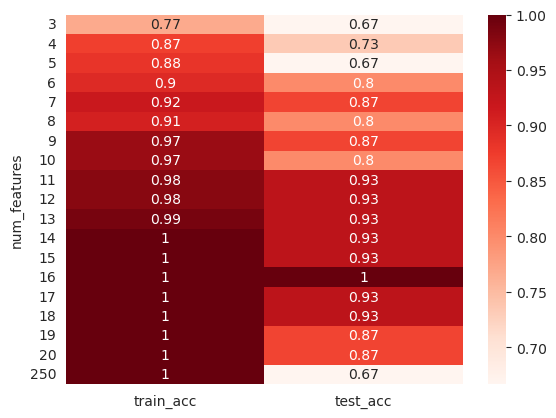

In [10]:
fig, ax = plt.subplots()
sns.heatmap(results_df.set_index('num_features'), cmap=sns.color_palette('Reds', as_cmap=True), vmax=1, annot=True, ax=ax)

ax.tick_params(axis='y', rotation=0)

outfn = os.path.join(outdir, 'rfe_analysis.svg')
fig.savefig(outfn)

In [11]:
rfe_selected_lists[9]

array(['CCL2', 'CD83', 'FGF23', 'GZMA', 'IL17RB', 'IL34', 'IL3RA', 'SPP1',
       'TNFRSF4'], dtype=object)

### Checking the model with these selected features using 5-fold cross validation

In [12]:
selected_n = 16
selected_features_list = rfe_selected_lists[selected_n]
print(f'num features: {len(selected_features_list)}')

num features: 16


In [13]:
def get_precision_recall_fscore_support_hvector(y_test, predictions, labels):
    
    report = precision_recall_fscore_support(y_test, predictions, labels=labels)
    report = pd.DataFrame(report, columns=labels, index=['precision', 'recall', 'fscore', 'support'])
    report = report.stack().swaplevel(1,0).sort_index().to_frame().T
    report.columns = [f'{i}_{j}' for i, j in report.columns]

    return(report.iloc[0])

In [14]:
labels = ['CD', 'UC']
results_skf = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
splits = skf.split(protein_data, task_data)
for i, (train_index, test_index) in enumerate(splits):

    # extract data from splits
    X_train, X_test = protein_data.iloc[train_index].loc[:,selected_features_list], protein_data.iloc[test_index].loc[:,selected_features_list]
    y_train, y_test = task_data.iloc[train_index], task_data.iloc[test_index]

    # get breakdown of the y test
    y_test_breakdown = pd.value_counts(y_test)
    # print(y_train.shape, y_test.shape)

    # resample to balance classes
    X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

    # Fit the model on the training data
    model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # Check the accuracy on the test data
    test_accuracy = model.score(X_test, y_test)

    # get the report
    predictions = model.predict(X_test)
    report = get_precision_recall_fscore_support_hvector(y_test, predictions, labels)

    # append results
    results_skf.append([i, train_accuracy, test_accuracy] + report.values.tolist())


/tmp/ipykernel_2720468/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_2720468/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_2720468/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_2720468/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_test_breakdown = pd.value_counts(y_test)
/tmp/ipykernel_2720468/4242356258.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future ve

In [15]:
#results_skf_df = pd.DataFrame(results_skf, columns=['fold', 'train_acc', 'test_acc'])
results_skf_df = pd.DataFrame(results_skf, columns=['fold', 'train_acc', 'test_acc'] + report.index.tolist())
results_skf_df

,fold,train_acc,test_acc,CD_fscore,CD_precision,CD_recall,CD_support,UC_fscore,UC_precision,UC_recall,UC_support
0,0,1.0,0.800000,0.857143,1.000000,0.750000,12.0,0.666667,0.500000,1.00,3.0
1,1,1.0,0.800000,0.869565,0.833333,0.909091,11.0,0.571429,0.666667,0.50,4.0
2,2,1.0,0.800000,0.857143,0.900000,0.818182,11.0,0.666667,0.600000,0.75,4.0
3,3,1.0,1.000000,1.000000,1.000000,1.000000,11.0,1.000000,1.000000,1.00,4.0
4,4,1.0,0.928571,0.952381,1.000000,0.909091,11.0,0.857143,0.750000,1.00,3.0


### Checking the model with these selected features using leave one out validation

In [16]:
results_loo = []
loo = LeaveOneOut()
splits = loo.split(protein_data, task_data)
for i, (train_index, test_index) in enumerate(splits):

    # extract data from splits
    X_train, X_test = protein_data.iloc[train_index].loc[:,selected_features_list], protein_data.iloc[test_index].loc[:,selected_features_list]
    y_train, y_test = task_data.iloc[train_index], task_data.iloc[test_index]

    # resample to balance classes
    X_train_resampled, y_train_resampled = RandomOverSampler(random_state=random_state).fit_resample(X_train, y_train)

    # Fit the model on the training data
    model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
    model.fit(X_train_resampled, y_train_resampled)

    # Check the accuracy on the training data
    train_accuracy = model.score(X_train_resampled, y_train_resampled)

    # get the match result
    pred = model.predict(X_test)[0]
    real = y_test.iloc[0]
    match = (pred == real)

    # append results
    results_loo.append([train_accuracy, pred, real, match])


In [17]:
results_loo_df = pd.DataFrame(results_loo, columns=['train_acc', 'predicted', 'true', 'match'])

In [18]:
cm_loo = results_loo_df[['predicted', 'true']].value_counts().sort_index()
cm_loo = cm_loo.to_frame().reset_index().pivot(index='true', columns='predicted', values='count')

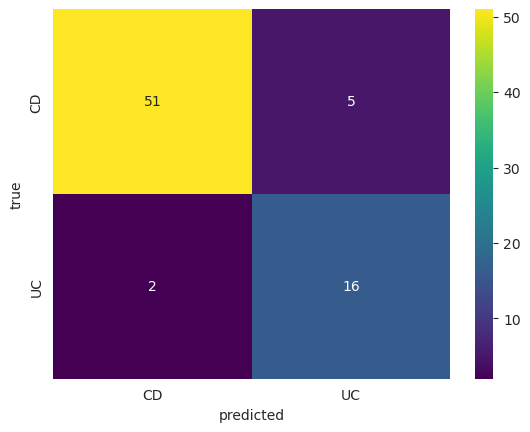

In [19]:
fig, ax = plt.subplots()

sns.heatmap(cm_loo, annot=True, cmap='viridis', ax=ax)

outfn = os.path.join(outdir, 'confusion_matrix.leave_one_out.svg')
fig.savefig(outfn)

In [20]:
results_loo_df['match'].value_counts()

match
True     67
False     7
Name: count, dtype: int64

In [21]:
results_loo_df['match'].value_counts(normalize=True) * 100

match
True     90.540541
False     9.459459
Name: proportion, dtype: float64

In [22]:
results_loo_df.value_counts(normalize=True) * 100

train_acc  predicted  true  match
0.990909   CD         CD    True     67.567568
1.000000   UC         UC    True     13.513514
0.982143   UC         UC    True      8.108108
1.000000   UC         CD    False     5.405405
           CD         UC    False     2.702703
0.990909   UC         CD    False     1.351351
1.000000   CD         CD    True      1.351351
Name: proportion, dtype: float64

In [23]:
results_loo_df

,train_acc,predicted,true,match
0,0.990909,UC,CD,False
1,0.990909,CD,CD,True
2,0.990909,CD,CD,True
3,0.982143,UC,UC,True
4,0.990909,CD,CD,True
...,...,...,...,...
69,0.990909,CD,CD,True
70,0.990909,CD,CD,True
71,0.990909,CD,CD,True
72,0.982143,UC,UC,True


In [24]:
fn = os.path.join(outdir, 'leave_one_out_validation.rfe16.tsv')
results_loo_df.to_csv(fn, sep='\t', index=False)

### ROC curve analysis

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(results_loo_df['true'])
y_onehot_test = label_binarizer.transform(results_loo_df['true'])
y_onehot_preds = label_binarizer.transform(results_loo_df['predicted'])

In [26]:
fpr, tpr, _ = roc_curve(y_onehot_test, y_onehot_preds)
roc_auc = auc(fpr, tpr)

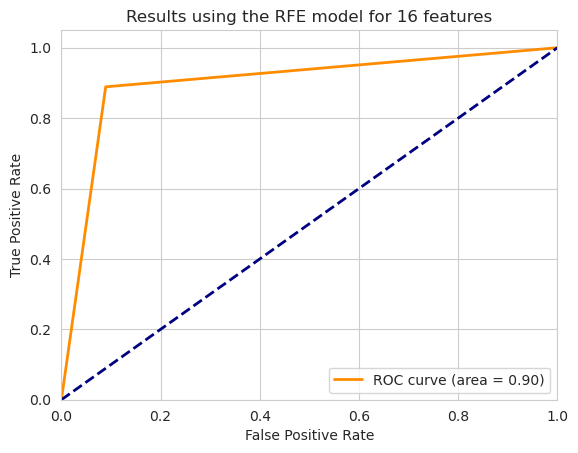

In [27]:
fig, ax = plt.subplots()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f'Results using the RFE model for {selected_n} features')
plt.legend(loc="lower right")
plt.show()

outfn = os.path.join(outdir, 'roc_curve.leave_one_out.svg')
fig.savefig(outfn)

### Saving a file with information on the 16 RFE model

In [28]:
# Create a new workbook
wb = Workbook()

# Create two sheets
sheet1 = wb.active
sheet1.title = "Sheet1"
sheet2 = wb.create_sheet(title="Sheet2")

# Lists of values
list1 = [1, 2, 3, 4, 5]
list2 = ['a', 'b', 'c', 'd', 'e']

# Add list2 to Sheet2
for idx, value in enumerate(list2, start=1):
    sheet2.cell(row=idx, column=1, value=value)

# Save the workbook
wb.save("example.xlsx")

In [29]:
# Fit the model on the training data
model = linear_model.LogisticRegression(random_state=0, max_iter=1000)
model.fit(protein_data.loc[:,selected_features_list], task_data)

# store the coefficients into a dataframe
coef_df = pd.DataFrame.from_dict({'protein': model.feature_names_in_.tolist(), 'coef': model.coef_.tolist()[0]}, orient='columns')
coef_df['abs_coef'] = coef_df['coef'].abs() 
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df['coef_cat'] = coef_df['coef'].apply(lambda x: '+' if x > 0 else '-')

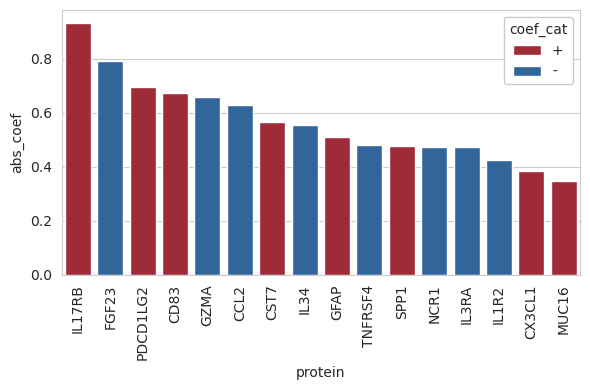

In [30]:
# plot the coefficients against one another
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(coef_df, x='protein', y='abs_coef', hue='coef_cat', palette={'+': '#b2182b', '-': '#2166ac'})
ax.tick_params(axis='x', rotation=90)

ax.legend(title='coef_cat', framealpha=1) 

fig.tight_layout()

coef_fn = os.path.join(outdir, 'logit_model.rfe_16_proteins.coefs.png')
fig.savefig(coef_fn, dpi=300)

In [31]:
# Save the DataFrame to an Excel file
outfn = os.path.join(outdir, 'logit_model.rfe_16_proteins.coefs.xlsx')
with pd.ExcelWriter(outfn, engine='openpyxl') as writer:
    coef_df.to_excel(writer, sheet_name='Sheet1', index=False)

# Load the workbook
wb = load_workbook(outfn)

# Select the sheet
sheet = wb["Sheet1"]

# Load an image
img = Image(coef_fn)
img.width = 6 * 96
img.height = 4 * 96

# Add the image to the sheet at a specific cell
sheet.add_image(img, 'F2')

# Save the workbook
wb.save(outfn)

## Predicting the IBD-U samples

In [68]:
# Load the protein levels data
ibdu_protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.npq.tsv", sep="\t").T

# Load the clinical data
ibdu_clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")
original_clinical_data = ibdu_clinical_data.copy(deep=True)

# remove alamar samples
keep = (~ibdu_clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
ibdu_clinical_data = ibdu_clinical_data.loc[keep,:]
ibdu_protein_data = ibdu_protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(ibdu_clinical_data['ibd_diagnosis'].isin(['IBD-U'])).reshape(-1)
ibdu_clinical_data = ibdu_clinical_data.iloc[focus_idxs]
ibdu_protein_data = ibdu_protein_data.iloc[focus_idxs, :]

In [43]:
# generate predictions
ibdu_preds = model.predict(ibdu_protein_data.loc[:, selected_features_list])
ibdu_clinical_data['cd_versus_uc_preds'] = ibdu_preds

In [47]:
# reorganize according to matched_subject_id
ibdu_clinical_data = ibdu_clinical_data.sort_values(['matched_subject_id', 'original_subject_id']).set_index(['matched_subject_id', 'original_subject_id'])

# save the data
outfn = os.path.join(outdir, 'ibdu_predictions.xlsx')
ibdu_clinical_data.to_excel(outfn, index=False)

### Diving into IBD-U samples using PCA with all RFE features

In [128]:
# create full data for training samples
tdf = results_loo_df.copy()
tdf.index = protein_data.index.tolist()
full_data1 = pd.concat([protein_data, tdf], axis=1)

# create full data for ibd-u samples
full_data2 = ibdu_protein_data.copy()
full_data2.loc[:, 'predicted'] = ibdu_preds
full_data2.loc[:, 'true'] = 'IBD-U'
full_data2.loc[:, 'match'] = False

# concat
full_data_with_ibdu = pd.concat([full_data1, full_data2])

# do the same for clinical data
full_clinical_with_ibdu = pd.concat([clinical_data, ibdu_clinical_data])
full_clinical_with_ibdu.sort_index(inplace=True)

In [129]:
full_data_with_ibdu.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A,train_acc,predicted,true,match
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241,0.990909,UC,CD,False
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622,0.990909,CD,CD,True
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245,0.990909,CD,CD,True
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645,0.982143,UC,UC,True
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662,0.990909,CD,CD,True


In [130]:
# Run PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(full_data_with_ibdu.loc[:, selected_features_list])

# make into a dataframe
principal_components = pd.DataFrame(principal_components, columns=['pc1', 'pc2', 'pc3'])

# add the index
principal_components.index = full_data_with_ibdu.index.tolist()

# add other columns
principal_components.loc[:, 'predicted'] = full_data_with_ibdu.loc[:, 'predicted']
principal_components.loc[:, 'true'] = full_data_with_ibdu.loc[:, 'true']
principal_components.loc[:, 'match'] = full_data_with_ibdu.loc[:, 'match']

# add the subject id
principal_components['matched_subject_id'] = full_clinical_with_ibdu.matched_subject_id.astype(str).values.tolist()

# # add subject error color depending on subjects that have at least one messed up sample
ibdu_subjects = full_clinical_with_ibdu.loc[full_clinical_with_ibdu.ibd_diagnosis == 'IBD-U', 'matched_subject_id'].unique().tolist()
principal_components['subject_ibdu_color'] = principal_components.matched_subject_id.apply(lambda x: x if float(x) in ibdu_subjects else 'other')

In [131]:
principal_components.head()

,pc1,pc2,pc3,predicted,true,match,matched_subject_id,subject_ibdu_color
TRP-34082,-5.439623,-9.530229,0.746947,UC,CD,False,1.0,other
TRP-34086,-3.472100,2.360266,-7.641869,CD,CD,True,3.0,other
TRP-42335,-9.481325,-5.872902,2.880043,CD,CD,True,7.0,other
TRP-42324,-4.692358,4.307616,0.842884,UC,UC,True,6.0,other
TRP-42322,2.867693,-6.836014,3.127472,CD,CD,True,5.0,other


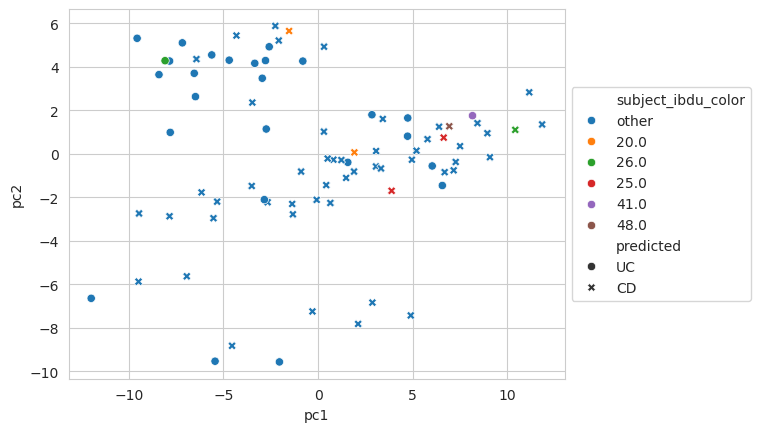

In [132]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_ibdu_color', style='predicted', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# outfn = os.path.join(outdir, 'pca.with_ibdu.rfe16.svg')
# fig.savefig(outfn)

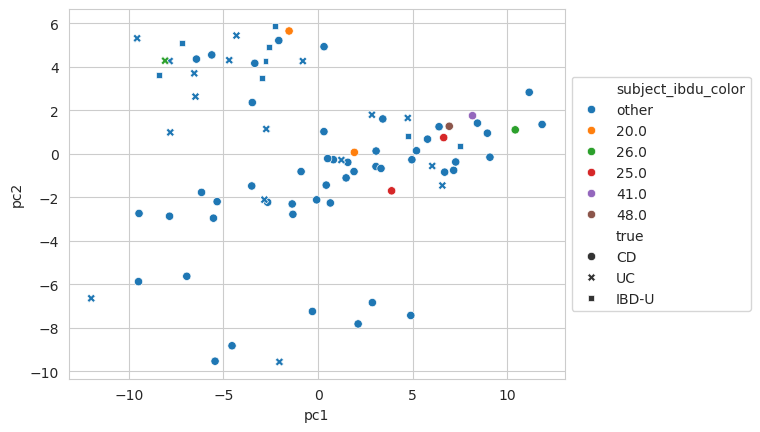

In [133]:
# Create a scatter plot of the PCA results
fig, ax = plt.subplots()
sns.scatterplot(x='pc1', y='pc2', hue='subject_ibdu_color', style='true', data=principal_components, ax=ax)

# Place the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# outfn = os.path.join(outdir, 'pca.with_ibdu.rfe16.svg')
# fig.savefig(outfn)

In [122]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [124]:
tcolors = {'other': 'blue',
            "20.0": 'orange',
            '26.0': 'green',
            '25.0': 'red',
            '41.0': 'purple',
            '48.0': 'brown'}

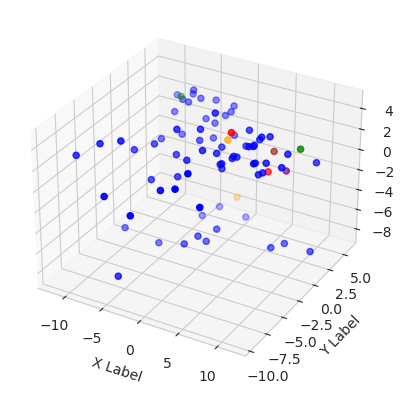

In [126]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

vcolors = [tcolors[x] for x in principal_components.subject_ibdu_color.tolist()]
ax.scatter(principal_components['pc1'], principal_components['pc2'], principal_components['pc3'], c=vcolors)
#ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show plot
plt.show()

### Correlation samples to one another using 16 RFE variables

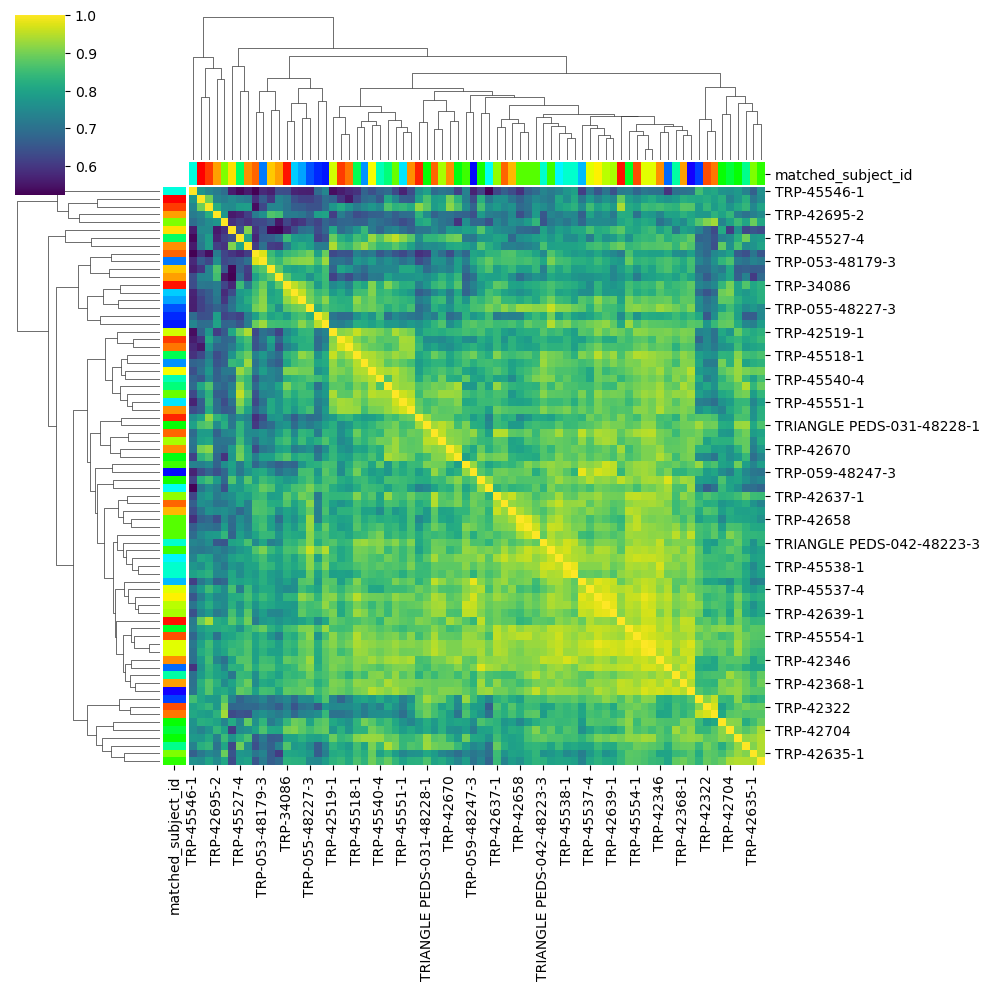

In [ ]:
# # calculate the correlation between samples
# subject_corrs = protein_data.loc[:, selected_features_list].transpose().corr()

# # assign colors to columns
# # add color to each subject
# nsubjects = principal_components.shape[0]
# cmap = plt.colormaps['hsv']
# hex_colors = [mcolors.rgb2hex(cmap(i/nsubjects)) for i in range(nsubjects)]
# colors_dict = dict(zip(principal_components['matched_subject_id'].unique(), hex_colors))
# colors_for_cols = principal_components['matched_subject_id'].map(colors_dict)

# # make the clustermap
# cg = sns.clustermap(subject_corrs, method='average', cmap='viridis', col_colors=colors_for_cols, row_colors=colors_for_cols)

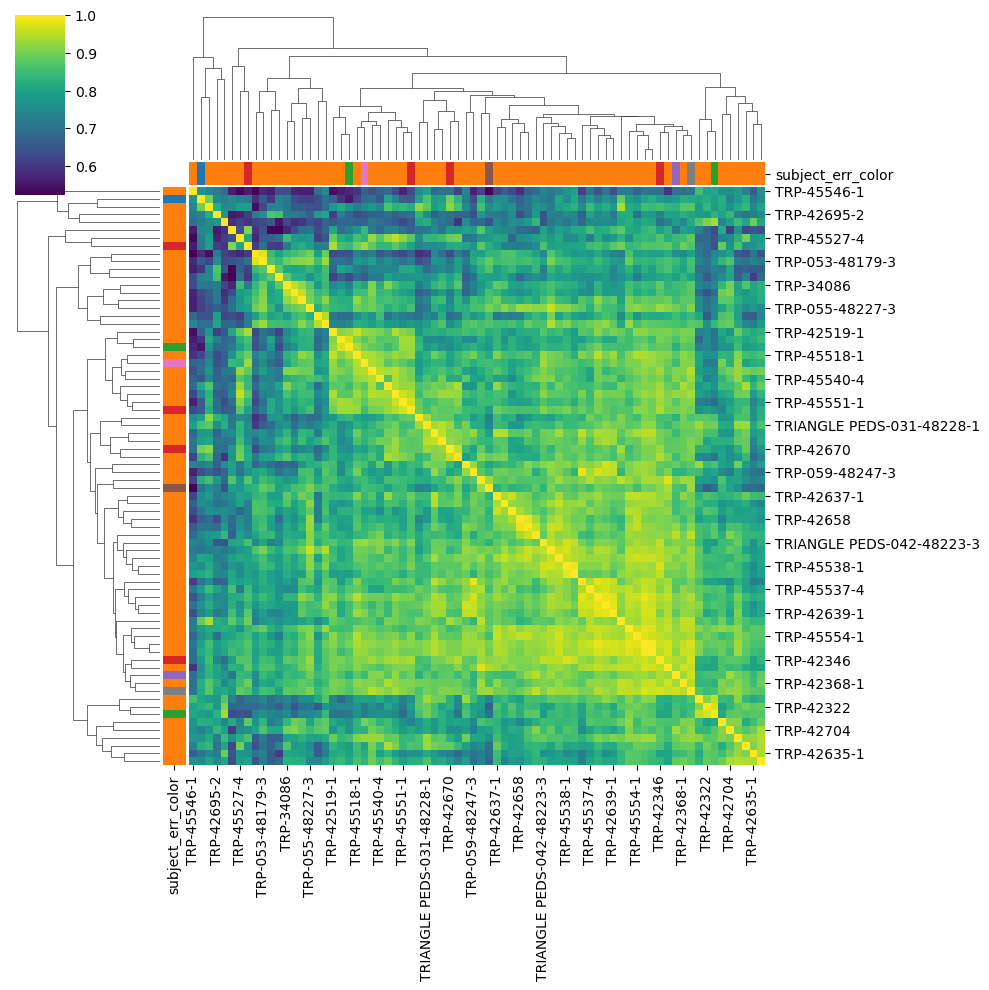

In [ ]:
# # calculate the correlation between samples
# subject_corrs = protein_data.loc[:, selected_features_list].transpose().corr()

# # assign colors to columns
# subject_err_to_color = principal_components['subject_err_color'].unique()
# colors = sns.color_palette().as_hex()
# colors_dict = dict(zip(subject_err_to_color, colors))
# colors_for_cols = principal_components['subject_err_color'].map(colors_dict)

# # make the clustermap
# cg = sns.clustermap(subject_corrs, method='average', cmap='viridis', col_colors=colors_for_cols, row_colors=colors_for_cols)


### Correlation samples to one another using all proteins

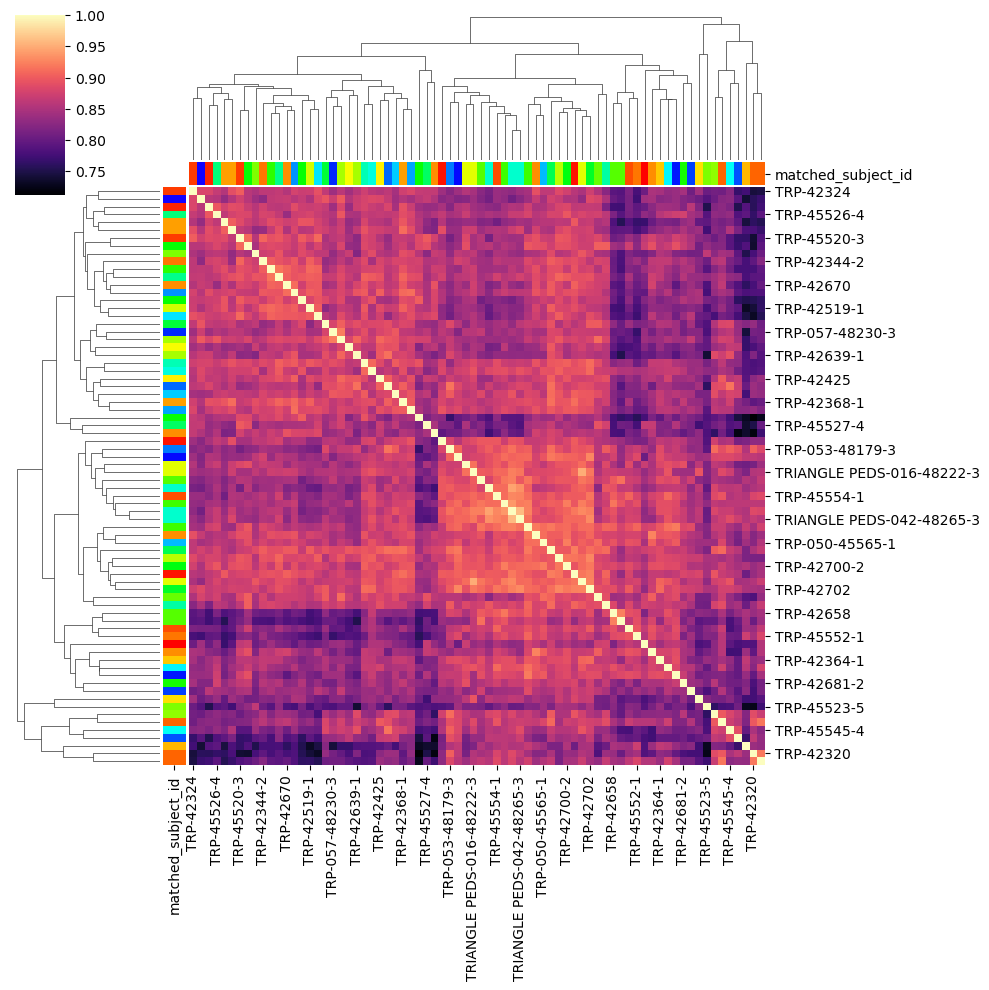

In [ ]:
# # calculate the correlation between samples
# subject_corrs = protein_data.transpose().corr()

# # assign colors to columns
# # add color to each subject
# nsubjects = principal_components.shape[0]
# cmap = plt.colormaps['hsv']
# hex_colors = [mcolors.rgb2hex(cmap(i/nsubjects)) for i in range(nsubjects)]
# colors_dict = dict(zip(principal_components['matched_subject_id'].unique(), hex_colors))
# colors_for_cols = principal_components['matched_subject_id'].map(colors_dict)

# # make the clustermap
# cg = sns.clustermap(subject_corrs, method='average', cmap='magma', col_colors=colors_for_cols, row_colors=colors_for_cols)

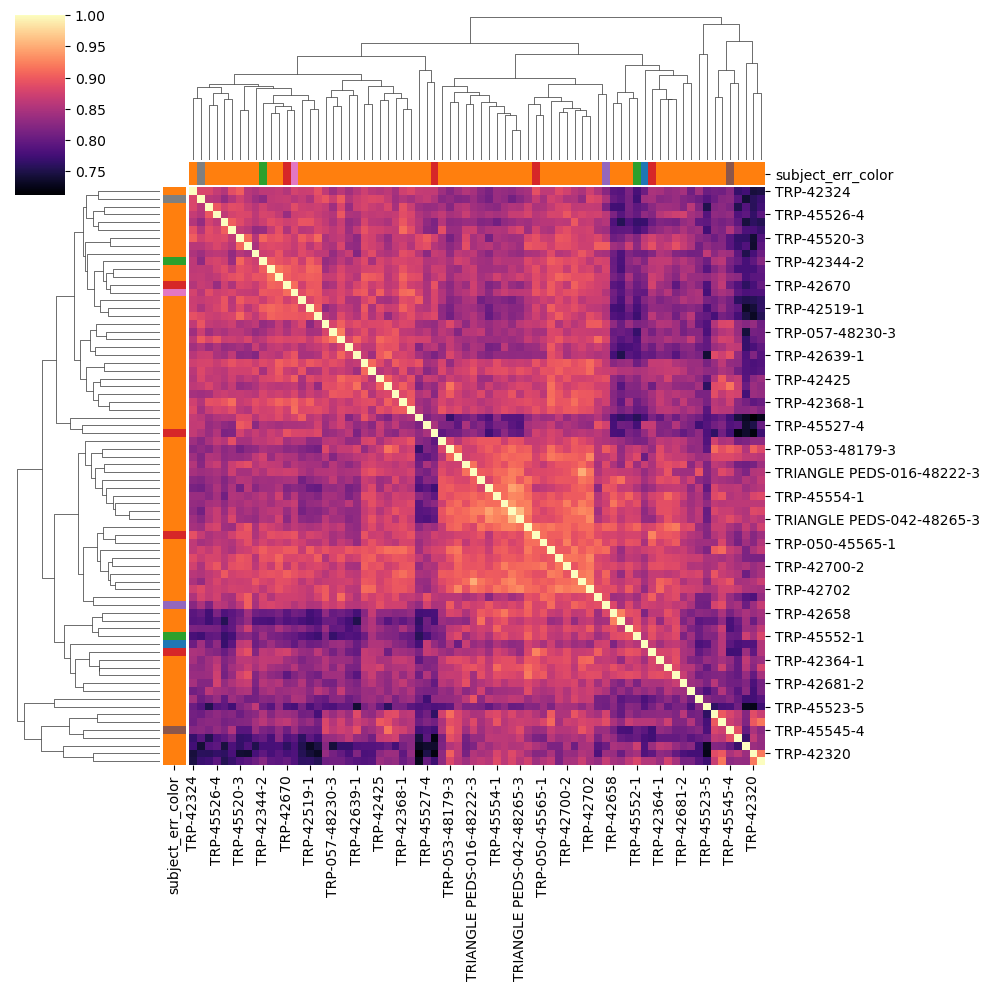

In [ ]:
# # calculate the correlation between samples
# subject_corrs = protein_data.transpose().corr()

# # assign colors to columns
# subject_err_to_color = principal_components['subject_err_color'].unique()
# colors = sns.color_palette().as_hex()
# colors_dict = dict(zip(subject_err_to_color, colors))
# colors_for_cols = principal_components['subject_err_color'].map(colors_dict)

# # make the clustermap
# cg = sns.clustermap(subject_corrs, method='average', cmap='magma', col_colors=colors_for_cols, row_colors=colors_for_cols)
